In [13]:
"""tsfresh interface class."""

__maintainer__ = []
__all__ = ["TSFresh", "TSFreshRelevant"]

import numpy as np
import pandas as pd

from aeon.transformations.collection.base import BaseCollectionTransformer
from aeon.utils.validation import check_n_jobs


def _from_3d_numpy_to_long(arr):
    # Converting the numpy array to a long format DataFrame
    n_cases, n_channels, n_timepoints = arr.shape

    # Creating a DataFrame from the numpy array with multi-level index
    df = pd.DataFrame(arr.reshape(n_cases * n_channels, n_timepoints))
    df["case_index"] = np.repeat(np.arange(n_cases), n_channels)
    df["dimension"] = np.tile(np.arange(n_channels), n_cases)
    df = df.melt(
        id_vars=["case_index", "dimension"], var_name="time_index", value_name="value"
    )

    # Adjusting the column order and renaming columns
    df = df[["case_index", "time_index", "dimension", "value"]]
    df = df.rename(columns={"case_index": "index", "dimension": "column"})
    df["column"] = "dim_" + df["column"].astype(str)
    return df


class _TSFresh(BaseCollectionTransformer):
    """Base adapter class for tsfresh transformations."""

    _tags = {
        "output_data_type": "Tabular",
        "capability:multivariate": True,
        "capability:multithreading": True,
        "fit_is_empty": True,
        "python_dependencies": "tsfresh",
    }

    def __init__(
        self,
        default_fc_parameters=None,
        kind_to_fc_parameters=None,
        chunksize=None,
        n_jobs=1,
        show_warnings=False,
        disable_progressbar=False,
        impute_function=None,
        profiling=None,
        profiling_filename=None,
        profiling_sorting=None,
        distributor=None,
    ):
        self.default_fc_parameters = default_fc_parameters
        self.kind_to_fc_parameters = kind_to_fc_parameters
        self.n_jobs = n_jobs
        self.chunksize = chunksize
        self.show_warnings = show_warnings
        self.disable_progressbar = disable_progressbar
        self.impute_function = impute_function
        self.profiling = profiling
        self.profiling_sorting = profiling_sorting
        self.profiling_filename = profiling_filename
        self.distributor = distributor

        super().__init__()

        # _get_extraction_params should be after the init because this imports tsfresh
        # and the init checks for python version and tsfresh being present
        self.default_fc_parameters_ = self._get_extraction_params()

    def _get_extraction_params(self):
        """Set default parameters from tsfresh."""
        # make n_jobs compatible with scikit-learn
        n_jobs = self.n_jobs
        self.n_jobs = check_n_jobs(self.n_jobs)

        # lazy imports to avoid hard dependency
        from tsfresh.defaults import (
            CHUNKSIZE,
            DISABLE_PROGRESSBAR,
            N_PROCESSES,
            PROFILING,
            PROFILING_FILENAME,
            PROFILING_SORTING,
            SHOW_WARNINGS,
        )
        from tsfresh.feature_extraction.settings import (
            ComprehensiveFCParameters,
            EfficientFCParameters,
            MinimalFCParameters,
            from_columns,
        )
        from tsfresh.utilities.dataframe_functions import impute

        # Set defaults from tsfresh
        extraction_params = {
            "n_jobs": N_PROCESSES,
            "chunksize": CHUNKSIZE,
            "show_warnings": SHOW_WARNINGS,
            "disable_progressbar": DISABLE_PROGRESSBAR,
            "impute_function": impute,
            "profiling_sorting": PROFILING_SORTING,
            "profiling_filename": PROFILING_FILENAME,
            "profile": PROFILING,
        }

        # Replace defaults with user defined parameters
        for name in extraction_params.keys():
            if hasattr(self, name):
                value = getattr(self, name)
                if value is not None:
                    extraction_params[name] = value

        self.n_jobs = n_jobs

        # Convert convenience string arguments to tsfresh parameters classes
        fc_param_lookup = {
            "minimal": MinimalFCParameters(),
            "efficient": EfficientFCParameters(),
            "comprehensive": ComprehensiveFCParameters(),
        }
        if isinstance(self.default_fc_parameters, str):
            if self.default_fc_parameters not in fc_param_lookup:
                raise ValueError(
                    f"If `default_fc_parameters` is passed as a "
                    f"string, "
                    f"it must be one of"
                    f" {fc_param_lookup.keys()}, but found: "
                    f"{self.default_fc_parameters}"
                )
            else:
                fc_parameters = fc_param_lookup[self.default_fc_parameters]
        else:
            fc_parameters = self.default_fc_parameters
        extraction_params["default_fc_parameters"] = fc_parameters

        # creates mapping from kind names to fc_parameter objects
        if self.kind_to_fc_parameters is not None:
            self.kind_to_fc_parameters_ = from_columns(self.kind_to_fc_parameters)
        else:
            self.kind_to_fc_parameters_ = self.kind_to_fc_parameters
        extraction_params["kind_to_fc_parameters"] = self.kind_to_fc_parameters_

        return extraction_params


class TSFresh(_TSFresh):
    """Transformer for extracting time series features via `tsfresh.extract_features`.

    Direct interface to `tsfresh.extract_features` [1] as an `aeon` transformer.

    Parameters
    ----------
    default_fc_parameters : str, FCParameters object or None,
        default=None = tsfresh default = "comprehensive"
        Specifies pre-defined feature sets to be extracted
        If str, should be in ["minimal", "efficient", "comprehensive"]
        See [3] for more details.
    kind_to_fc_parameters : list or None, default=None
        List containing strings specifying selected features to be extracted.
        The naming convention from tsfresh applies, i.e. the strings
        should be structured as:
        {time_series_name}__{feature_name}__{param name 1}_
        {param value 1}__[..]__{param name k}_{param value k}.
        See [2] for more details and [4] for viable options.
        Either default_fc_parameters or kind_to_fc_parameters
        should be passed. If both are passed, only features specified
        in kind_to_fc_parameters are extracted. If neither
        is passed, it calculates the "comprehensive"
        feature set.
    n_jobs : int, default=1
        The number of processes to use for parallelization.
        If zero, no parallelization is used.
    chunksize : None or int, default=None
        The size of one chunk that is submitted to the worker
        process for the parallelisation.  Where one chunk is defined as a
        singular time series for one id and one kind. If you set the chunksize
        to 10, then it means that one task is to calculate all features for 10
        time series.  If it is set it to None, depending on distributor,
        heuristics are used to find the optimal chunksize. If you get out of
        memory exceptions, you can try it with the dask distributor and a
        smaller chunksize.
    show_warnings : bool, default=True
        Show warnings during the feature extraction (needed for debugging of
        calculators).
    disable_progressbar : bool, default=False
        Do not show a progressbar while doing the calculation.
    impute_function : None or Callable, default=None
        None, if no imputing should happen or the function to call for
        imputing the result dataframe. Imputing will never happen on the input data.
    profiling : bool, default=None
        Turn on profiling during feature extraction.
    profiling_sorting : basestring, default=None
        How to sort the profiling results (see the documentation of the tsfresh
        profiling package for more information).
    profiling_filename : basestring, default=None
        Where to save the profiling results.
    distributor : distributor class, default=None
        Advanced parameter: set this to a class name that you want to use as a
        distributor. See the tsfresh package utilities/distribution.py for more
        information.
        Leave to None, if you want TSFresh to choose the best distributor.

    References
    ----------
    .. [1]  https://github.com/blue-yonder/tsfresh
    .. [2]  https://tsfresh.readthedocs.io/en/v0.1.2/text/feature_naming.html
    .. [3]  https://tsfresh.readthedocs.io/en/latest/text/
            feature_extraction_settings.html
    .. [4]  https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html
            #module-tsfresh.feature_extraction.feature_calculators
    .. [5] Christ, M., Braun, N., Neuffer, J., and Kempa-Liehr A.W. (2018). Time Series
        FeatuRe Extraction on basis of Scalable Hypothesis tests (tsfresh -- A Python
        package). Neurocomputing 307 (2018) 72-77

    Examples
    --------
    >>> from sklearn.model_selection import train_test_split
    >>> from aeon.datasets import load_arrow_head
    >>> from aeon.transformations.collection.feature_based import (
    ...     TSFresh
    ... )
    >>> X, y = load_arrow_head()
    >>> X_train, X_test, y_train, y_test = train_test_split(X, y)
    >>> ts_eff = TSFresh(
    ...     default_fc_parameters="efficient", disable_progressbar=True
    ... ) # doctest: +SKIP
    >>> X_transform1 = ts_eff.fit_transform(X_train) # doctest: +SKIP
    >>> features_to_calc = [
    ...     "dim_0__quantile__q_0.6",
    ...     "dim_0__longest_strike_above_mean",
    ...     "dim_0__variance",
    ... ]
    >>> ts_custom = TSFresh(
    ...     kind_to_fc_parameters=features_to_calc, disable_progressbar=True
    ... ) # doctest: +SKIP
    >>> X_transform2 = ts_custom.fit_transform(X_train) # doctest: +SKIP
    """

    def __init__(
        self,
        default_fc_parameters="efficient",
        kind_to_fc_parameters=None,
        chunksize=None,
        n_jobs=1,
        show_warnings=False,
        disable_progressbar=True,
        impute_function=None,
        profiling=None,
        profiling_filename=None,
        profiling_sorting=None,
        distributor=None,
    ):
        super().__init__(
            default_fc_parameters=default_fc_parameters,
            kind_to_fc_parameters=kind_to_fc_parameters,
            chunksize=chunksize,
            n_jobs=n_jobs,
            show_warnings=show_warnings,
            disable_progressbar=disable_progressbar,
            impute_function=impute_function,
            profiling=profiling,
            profiling_filename=profiling_filename,
            profiling_sorting=profiling_sorting,
            distributor=distributor,
        )
        self._get_names()

    def _transform(self, X, y=None):
        """Transform X and return a transformed version.

        private _transform containing core logic, called from transform

        Parameters
        ----------
        X : 3D numpy array of shape (n_cases, n_channels, n_features)
            input time series collection.
        y : ignored argument for interface compatibility

        Returns
        -------
        X : 3D numpy array of shape (n_cases, n_channels, n_features)
            input time series collection.
            transformed version of X
        """
        Xt = _from_3d_numpy_to_long(X)

        # lazy imports to avoid hard dependency
        from tsfresh import extract_features

        Xt = extract_features(
            Xt,
            column_id="index",
            column_value="value",
            column_kind="column",
            column_sort="time_index",
            **self.default_fc_parameters_,
        )
        return Xt.to_numpy()

    @classmethod
    def _get_test_params(cls, parameter_set="default"):
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.


        Returns
        -------
        params : dict or list of dict, default = {}
            Parameters to create testing instances of the class
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
        """
        features_to_calc = [
            "dim_0__quantile__q_0.6",
            "dim_0__longest_strike_above_mean",
            "dim_0__variance",
        ]

        return [
            {
                "disable_progressbar": True,
                "show_warnings": False,
                "default_fc_parameters": "minimal",
            },
            {
                "disable_progressbar": True,
                "show_warnings": False,
                "kind_to_fc_parameters": features_to_calc,
            },
        ]

    def _get_names(self):
        """Hack to get the feature names prior to transform."""
        from tsfresh import extract_features

        X = np.random.random((2, 1, 30))
        Xt = _from_3d_numpy_to_long(X)
        Xt = extract_features(
            Xt,
            column_id="index",
            column_value="value",
            column_kind="column",
            column_sort="time_index",
            **self.default_fc_parameters_,
        )
        # Get the list of feature names
        self.names = Xt.columns.tolist()


class TSFreshRelevant(_TSFresh):
    """Transformer for extracting time series features via `tsfresh.extract_features`.

    Direct interface to `tsfresh.extract_features` [1] followed by the tsfresh
    FeatureSelector class as an `aeon` transformer.

    Parameters
    ----------
    default_fc_parameters : str, FCParameters object or None,
        default=None = tsfresh default = "comprehensive"
        Specifies pre-defined feature sets to be extracted
        If str, should be in ["minimal", "efficient", "comprehensive"]
        See [3] for more details.
    kind_to_fc_parameters : list or None, default=None
        List containing strings specifying selected features to be extracted.
        The naming convention from tsfresh applies, i.e. the strings
        should be structured as:
        {time_series_name}__{feature_name}__{param name 1}_
        {param value 1}__[..]__{param name k}_{param value k}.
        See [2] for more details and [4] for viable options.
        Either default_fc_parameters or kind_to_fc_parameters
        should be passed. If both are passed, only features specified
        in kind_to_fc_parameters are extracted. If neither
        is passed, it calculates the "comprehensive"
        feature set.
    n_jobs : int, default=1
        The number of processes to use for parallelization.
        If zero, no parallelization is used.
    chunksize : None or int, default=None
        The size of one chunk that is submitted to the worker
        process for the parallelisation.  Where one chunk is defined as a
        singular time series for one id and one kind. If you set the chunksize
        to 10, then it means that one task is to calculate all features for 10
        time series.  If it is set it to None, depending on distributor,
        heuristics are used to find the optimal chunksize. If you get out of
        memory exceptions, you can try it with the dask distributor and a
        smaller chunksize.
    show_warnings : bool, default=False
        Show warnings during the feature extraction (needed for debugging of
        calculators).
    disable_progressbar : bool, default=False
        Do not show a progressbar while doing the calculation.
    impute_function : None or Callable, default=None
        None, if no imputing should happen or the function to call for
        imputing the result dataframe. Imputing will never happen on the input data.
    profiling : bool, default=None
        Turn on profiling during feature extraction.
    profiling_sorting : basestring, default=None
        How to sort the profiling results (see the documentation of the tsfresh
        profiling package for more information).
    profiling_filename : basestring, default=None
        Where to save the profiling results.
    distributor : distributor class, default=None
        Advanced parameter: set this to a class name that you want to use as a
        distributor. See the tsfresh package utilities/distribution.py for more
        information.
        Leave to None, if you want TSFresh to choose the best distributor.
    test_for_binary_target_binary_feature : str or None, default=None
        Which test to be used for binary target, binary feature (currently unused).
    test_for_binary_target_real_feature : str or None, default=None
        Which test to be used for binary target, real feature.
    test_for_real_target_binary_feature : str or None, default=None
        Which test to be used for real target, binary feature (currently unused).
    test_for_real_target_binary_feature : str or None, default=None
        Which test to be used for real target, real feature (currently unused)
    fdr_level: float or None, default=None
        The FDR level that should be respected, this is the theoretical expected
        percentage of irrelevant features among all created features.
    hypotheses_independent: bool or None, default=None
        Can the significance of the features be assumed to be independent? Normally,
        this should be set to False as the features are never independent (e.g. mean
        and median)
    ml_task: sre, default="auto"
        The intended machine learning task. Either `'classification'`, `'regression'`
        or `'auto'`.
        Defaults to `'auto'`, meaning the intended task is inferred from `y`.
        If `y` has a boolean, integer or object dtype, the task is assumed to be
        classification, else regression.

    References
    ----------
    .. [1]  https://github.com/blue-yonder/tsfresh
    .. [2]  https://tsfresh.readthedocs.io/en/v0.1.2/text/feature_naming.html
    .. [3]  https://tsfresh.readthedocs.io/en/latest/text/
            feature_extraction_settings.html
    .. [4]  https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html
            #module-tsfresh.feature_extraction.feature_calculators
    .. [5] Christ, M., Braun, N., Neuffer, J., and Kempa-Liehr A.W. (2018). Time Series
        FeatuRe Extraction on basis of Scalable Hypothesis tests (tsfresh -- A Python
        package). Neurocomputing 307 (2018) 72-77

    Examples
    --------
    >>> from sklearn.model_selection import train_test_split
    >>> from aeon.datasets import load_arrow_head
    >>> from aeon.transformations.collection.feature_based import (
    ...     TSFreshRelevant
    ... )
    >>> X, y = load_arrow_head()
    >>> X_train, X_test, y_train, y_test = train_test_split(X, y)
    >>> ts_eff = TSFreshRelevant(
    ...     default_fc_parameters="efficient", disable_progressbar=True
    ... ) # doctest: +SKIP
    >>> X_transform1 = ts_eff.fit_transform(X_train, y_train) # doctest: +SKIP
    >>> features_to_calc = [
    ...     "dim_0__quantile__q_0.6",
    ...     "dim_0__longest_strike_above_mean",
    ...     "dim_0__variance",
    ... ]
    >>> ts_custom = TSFreshRelevant(
    ...     kind_to_fc_parameters=features_to_calc, disable_progressbar=True
    ... ) # doctest: +SKIP
    >>> X_transform2 = ts_custom.fit_transform(X_train, y_train) # doctest: +SKIP
    """

    _tags = {
        "requires_y": True,
        "X_inner_type": "numpy3D",
        "fit_is_empty": False,
    }

    def __init__(
        self,
        default_fc_parameters="efficient",
        kind_to_fc_parameters=None,
        chunksize=None,
        n_jobs=1,
        show_warnings=False,
        disable_progressbar=True,
        impute_function=None,
        profiling=None,
        profiling_filename=None,
        profiling_sorting=None,
        distributor=None,
        test_for_binary_target_binary_feature=None,
        test_for_binary_target_real_feature=None,
        test_for_real_target_binary_feature=None,
        test_for_real_target_real_feature=None,
        fdr_level=None,
        hypotheses_independent=None,
        ml_task="auto",
    ):
        super().__init__(
            default_fc_parameters=default_fc_parameters,
            kind_to_fc_parameters=kind_to_fc_parameters,
            chunksize=chunksize,
            n_jobs=n_jobs,
            show_warnings=show_warnings,
            disable_progressbar=disable_progressbar,
            impute_function=impute_function,
            profiling=profiling,
            profiling_filename=profiling_filename,
            profiling_sorting=profiling_sorting,
            distributor=distributor,
        )

        self.test_for_binary_target_binary_feature = (
            test_for_binary_target_binary_feature
        )
        self.test_for_binary_target_real_feature = test_for_binary_target_real_feature
        self.test_for_real_target_binary_feature = test_for_real_target_binary_feature
        self.test_for_real_target_real_feature = test_for_real_target_real_feature
        self.fdr_level = fdr_level
        self.hypotheses_independent = hypotheses_independent
        self.ml_task = ml_task

        self.default_fs_parameters_ = self._get_selection_params()
        self.names_ = []

    def _get_selection_params(self):
        """Set default values from tsfresh."""
        # lazy imports to avoid hard dependency
        from tsfresh.defaults import (
            FDR_LEVEL,
            HYPOTHESES_INDEPENDENT,
            TEST_FOR_BINARY_TARGET_BINARY_FEATURE,
            TEST_FOR_BINARY_TARGET_REAL_FEATURE,
            TEST_FOR_REAL_TARGET_BINARY_FEATURE,
            TEST_FOR_REAL_TARGET_REAL_FEATURE,
        )

        # Set defaults
        selection_params = {
            "test_for_binary_target_binary_feature": TEST_FOR_BINARY_TARGET_BINARY_FEATURE,  # noqa: E501
            "test_for_binary_target_real_feature": TEST_FOR_BINARY_TARGET_REAL_FEATURE,
            "test_for_real_target_binary_feature": TEST_FOR_REAL_TARGET_BINARY_FEATURE,
            "test_for_real_target_real_feature": TEST_FOR_REAL_TARGET_REAL_FEATURE,
            "fdr_level": FDR_LEVEL,
            "hypotheses_independent": HYPOTHESES_INDEPENDENT,
        }

        # Replace defaults with user defined parameters
        for name in selection_params.keys():
            value = getattr(self, name)
            if value is not None:
                selection_params[name] = value

        return selection_params

    def _fit_transform(self, X, y=None):
        """Fit to data, then transform it.

        Fits the transformer to X and y and returns a transformed version of X.

        State change:
            Changes state to "fitted".

        Writes to self:
        _is_fitted : flag is set to True.

        Parameters
        ----------
        X : 3D np.ndarray of shape (n_cases, n_channels, n_timepoints)
            collection of time series to transform
        y : Series, default=None
            Additional data, e.g., labels for transformation

        Returns
        -------
        transformed version of X
        """
        # lazy imports to avoid hard dependency
        from tsfresh.transformers.feature_selector import FeatureSelector

        self.extractor_ = TSFresh(
            default_fc_parameters=self.default_fc_parameters,
            kind_to_fc_parameters=self.kind_to_fc_parameters,
            chunksize=self.chunksize,
            n_jobs=self.n_jobs,
            show_warnings=self.show_warnings,
            disable_progressbar=self.disable_progressbar,
            profiling=self.profiling,
            profiling_filename=self.profiling_filename,
            profiling_sorting=self.profiling_sorting,
        )

        self.selector_ = FeatureSelector(
            n_jobs=self.default_fc_parameters_["n_jobs"],
            chunksize=self.default_fc_parameters_["chunksize"],
            ml_task=self.ml_task,
            **self.default_fs_parameters_,
        )

        Xt = self.extractor_.fit_transform(X)
        Xt = self.selector_.fit_transform(Xt, y)
        self.names_ = self.selector_.relevant_features
        return Xt

    def _fit(self, X, y=None):
        """Fit.

        Parameters
        ----------
        X : pd.DataFrame
            nested pandas DataFrame of shape [n_samples, n_columns]
        y : pd.Series or np.array
            Target variable

        Returns
        -------
        self : an instance of self
        """
        # lazy imports to avoid hard dependency
        from tsfresh.transformers.feature_selector import FeatureSelector

        self.extractor_ = TSFresh(
            default_fc_parameters=self.default_fc_parameters,
            kind_to_fc_parameters=self.kind_to_fc_parameters,
            chunksize=self.chunksize,
            n_jobs=self.n_jobs,
            show_warnings=self.show_warnings,
            disable_progressbar=self.disable_progressbar,
            profiling=self.profiling,
            profiling_filename=self.profiling_filename,
            profiling_sorting=self.profiling_sorting,
        )

        self.selector_ = FeatureSelector(
            n_jobs=self.default_fc_parameters_["n_jobs"],
            chunksize=self.default_fc_parameters_["chunksize"],
            ml_task=self.ml_task,
            **self.default_fs_parameters_,
        )

        Xt = self.extractor_.fit_transform(X)
        self.selector_.fit(Xt, y)
        self.names_ = self.selector_.relevant_features
        return self

    def _transform(self, X, y=None):
        """Transform X.

        Parameters
        ----------
        X : np.ndarray
        y : None
            Ignored

        Returns
        -------
        Xt : np.ndarray
          Transformed data
        """
        Xt = self.extractor_.transform(X)
        Xt = self.selector_.transform(Xt)
        return Xt

    @classmethod
    def _get_test_params(cls, parameter_set="default"):
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.


        Returns
        -------
        params : dict or list of dict, default = {}
            Parameters to create testing instances of the class
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
        """
        params = {
            "default_fc_parameters": "efficient",
            "disable_progressbar": True,
            "show_warnings": False,
            "fdr_level": 0.01,
        }
        return params

In [14]:
"""FreshPRINCEClassifier.

Pipeline classifier using the full set of TSFresh features and a
RotationForestClassifier.
"""

__maintainer__ = ["MatthewMiddlehurst"]
__all__ = ["FreshPRINCEClassifier"]

import numpy as np
from sklearn.tree import DecisionTreeClassifier

from aeon.classification.base import BaseClassifier
from aeon.classification.sklearn import RotationForestClassifier
#from aeon.transformations.collection.feature_based import TSFresh


class FreshPRINCEClassifier(BaseClassifier):
    """
    Fresh Pipeline with RotatIoN forest Classifier.

    This classifier simply transforms the input data using the TSFresh [1]_
    transformer with comprehensive features and builds a RotationForestClassifier
    estimator using the transformed data.

    Parameters
    ----------
    default_fc_parameters : str, default="comprehensive"
        Set of TSFresh features to be extracted, options are "minimal", "efficient" or
        "comprehensive".
    n_estimators : int, default=200
        Number of estimators for the RotationForestClassifier ensemble.
    base_estimator : BaseEstimator or None, default="None"
        Base estimator for the ensemble. By default, uses the sklearn
        `DecisionTreeClassifier` using entropy as a splitting measure.
    pca_solver : str, default="auto"
        Solver to use for the PCA ``svd_solver`` parameter in rotation forest. See the
        scikit-learn PCA implementation for options.
    verbose : int, default=0
        Level of output printed to the console (for information only).
    n_jobs : int, default=1
        The number of jobs to run in parallel for both `fit` and `predict`.
        ``-1`` means using all processors.
    chunksize : int or None, default=None
        Number of series processed in each parallel TSFresh job, should be optimised
        for efficient parallelisation.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.

    Attributes
    ----------
    n_classes_ : int
        Number of classes. Extracted from the data.
    classes_ : ndarray of shape (n_classes_)
        Holds the label for each class.

    See Also
    --------
    TSFresh, TSFreshClassifier, RotationForestClassifier
        TSFresh related classes.

    References
    ----------
    .. [1] Christ, Maximilian, et al. "Time series feature extraction on basis of
        scalable hypothesis tests (tsfresh-a python package)." Neurocomputing 307
        (2018): 72-77.
        https://www.sciencedirect.com/science/article/pii/S0925231218304843
    .. [2] Middlehurst, M., Bagnall, A. "The FreshPRINCE: A Simple Transformation
        Based Pipeline Time Series Classifier." In: El Yacoubi, M., Granger, E.,
        Yuen, P.C., Pal, U., Vincent, N. (eds) Pattern Recognition and Artificial
        Intelligence. ICPRAI 2022. Lecture Notes in Computer Science, vol 13364.
        Springer, Cham. (2022).
        https://link.springer.com/chapter/10.1007/978-3-031-09282-4_13
    """

    _tags = {
        "capability:multivariate": True,
        "capability:multithreading": True,
        "capability:train_estimate": True,
        "algorithm_type": "feature",
        "python_dependencies": "tsfresh",
    }

    def __init__(
        self,
        default_fc_parameters="comprehensive",
        n_estimators=200,
        base_estimator=None,
        pca_solver="auto",
        verbose=0,
        n_jobs=1,
        chunksize=None,
        random_state=None,
    ):
        self.default_fc_parameters = default_fc_parameters
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator
        self.pca_solver = pca_solver

        self.verbose = verbose
        self.n_jobs = n_jobs
        self.chunksize = chunksize
        self.random_state = random_state

        self.n_cases_ = 0
        self.n_channels_ = 0
        self.n_timepoints_ = 0

        self._rotf = None
        self._tsfresh = None

        super().__init__()

    def _fit(self, X, y):
        """Fit a pipeline on cases (X,y), where y is the target variable.

        Parameters
        ----------
        X : 3D np.ndarray
            The training data shape = (n_cases, n_channels, n_timepoints).
        y : 1D np.ndarray
            The training labels, shape = (n_cases).

        Returns
        -------
        self :
            Reference to self.

        Notes
        -----
        Changes state by creating a fitted model that updates attributes
        ending in "_" and sets is_fitted flag to True.
        """
        X_t = self._fit_fp_shared(X, y)
        self._rotf.fit(X_t, y)
        return self

    def _predict(self, X) -> np.ndarray:
        """Predict class values of n instances in X.

        Parameters
        ----------
        X : 3D np.ndarray
            The data to make predictions for, shape = (n_cases, n_channels,
            n_timepoints).

        Returns
        -------
        y : 1D np.ndarray
            The predicted class labels, shape = (n_cases).
        """
        return self._rotf.predict(self._tsfresh.transform(X))

    def _predict_proba(self, X) -> np.ndarray:
        """Predict class probabilities for n instances in X.

        Parameters
        ----------
        X : 3D np.ndarray
            The data to make predictions for, shape = (n_cases, n_channels,
            n_timepoints).

        Returns
        -------
        y : 2D np.ndarray
            Predicted probabilities using the ordering in classes_ shape = (
            n_cases, n_classes_).
        """
        return self._rotf.predict_proba(self._tsfresh.transform(X))

    def _fit_predict(self, X, y) -> np.ndarray:
        X_t = self._fit_fp_shared(X, y)
        return self._rotf.fit_predict(X_t, y)

    def _fit_predict_proba(self, X, y) -> np.ndarray:
        X_t = self._fit_fp_shared(X, y)
        return self._rotf.fit_predict_proba(X_t, y)

    def _fit_fp_shared(self, X, y):
        self.n_cases_, self.n_channels_, self.n_timepoints_ = X.shape

        self._rotf = RotationForestClassifier(
            n_estimators=self.n_estimators,
            base_estimator=self.base_estimator,
            #pca_solver=self.pca_solver,
            n_jobs=self._n_jobs,
            random_state=self.random_state,
        )
        self._tsfresh = TSFresh(
            default_fc_parameters=self.default_fc_parameters,
            n_jobs=self._n_jobs,
            chunksize=self.chunksize,
            show_warnings=self.verbose > 1,
            disable_progressbar=self.verbose < 1,
        )

        return self._tsfresh.fit_transform(X, y)

    @classmethod
    def _get_test_params(cls, parameter_set="default"):
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.
            FreshPRINCEClassifier provides the following special sets:
                 "results_comparison" - used in some classifiers to compare against
                    previously generated results where the default set of parameters
                    cannot produce suitable probability estimates
                "train_estimate" - used in some classifiers that set the
                    "capability:train_estimate" tag to True to allow for more efficient
                    testing when relevant parameters are available

        Returns
        -------
        params : dict or list of dict, default={}
            Parameters to create testing instances of the class.
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
        """
        if parameter_set == "results_comparison":
            return {
                "n_estimators": 10,
                "base_estimator": DecisionTreeClassifier(
                    criterion="entropy", max_depth=3
                ),
                "pca_solver": "full",
                "default_fc_parameters": "minimal",
            }
        else:
            return {
                "n_estimators": 2,
                "default_fc_parameters": "minimal",
            }

In [15]:
import random

import numpy as np
import torch
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [16]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct  # Import DCT from scipy
import librosa  # Ensure librosa is imported for loading audio files

# Custom Dataset Class
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

def pre_emphasis(signal, alpha=0.97):
    """Apply pre-emphasis filter."""
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def framing(signal, frame_size, hop_size):
    """Split signal into overlapping frames."""
    num_frames = int(np.ceil(float(np.abs(len(signal) - frame_size)) / hop_size)) + 1
    pad_signal_length = num_frames * hop_size + frame_size
    z = np.zeros(pad_signal_length)
    z[:len(signal)] = signal
    
    frames = np.lib.stride_tricks.as_strided(z,
        shape=(num_frames, frame_size),
        strides=(z.strides[0] * hop_size, z.strides[0])).copy()
    
    return frames

def hamming_window(frame):
    """Apply Hamming window to a frame."""
    return np.hamming(len(frame)) * frame

def mel_filter_bank(num_filters, fft_size, sample_rate, low_freq=0, high_freq=None):
    """Create a Mel filter bank."""
    if high_freq is None:
        high_freq = sample_rate / 2
    
    # Convert frequency to Mel scale
    low_mel = 2595 * np.log10(1 + low_freq / 700)
    high_mel = 2595 * np.log10(1 + high_freq / 700)
    
    mel_points = np.linspace(low_mel, high_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)
    
    filters = np.zeros((num_filters, int(np.floor(fft_size / 2 + 1))))
    
    for n in range(1, num_filters + 1):
        filters[n - 1, bin_points[n - 1]:bin_points[n]] = \
            (np.arange(bin_points[n - 1], bin_points[n]) - bin_points[n - 1]) / (bin_points[n] - bin_points[n - 1])
        filters[n - 1, bin_points[n]:bin_points[n + 1]] = \
            (bin_points[n + 1] - np.arange(bin_points[n], bin_points[n + 1])) / (bin_points[n + 1] - bin_points[n])
    
    return filters

def compute_mfcc(signal, sample_rate=16000, n_mfcc=13, n_fft=400, hop_length=240):
    """Compute MFCC from scratch."""
    # Step 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal)

    # Step 2: Framing
    frames = framing(emphasized_signal, n_fft, hop_length)

    # Step 3: Apply Hamming window
    windowed_frames = np.array([hamming_window(frame) for frame in frames])

    # Step 4: FFT and Power Spectrum
    mag_frames = np.abs(np.fft.rfft(windowed_frames, n=n_fft)) ** 2

    # Step 5: Mel Filter Bank
    mel_filters = mel_filter_bank(n_mfcc, n_fft, sample_rate)
    
    # Step 6: Apply Mel filter bank to power spectrum
    mel_energies = np.dot(mag_frames, mel_filters.T)

    # Step 7: Logarithm of Mel energies
    log_mel_energies = np.log(mel_energies + np.finfo(float).eps)

    # Step 8: Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_energies, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    return mfccs

def load_data_with_mfcc(directory, n_mfcc=13, n_fft=400, hop_size=240, target_length=16000):
    """Load data from a directory and extract MFCC features."""
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    signal, rate = librosa.load(file_path, sr=None)  # Load audio to get its length
                    
                    # Check if the audio signal length is less than the target length (16000 samples)
                    if len(signal) < target_length:
                        # Pad the signal to 16000 samples if it's too short
                        padding = target_length - len(signal)
                        signal = np.pad(signal, (0, padding), 'constant')

                    # Check if the audio length is greater than the target length (16000 samples)
                    if len(signal) > target_length:
                        # Truncate the signal to 16000 samples if it's too long
                        signal = signal[:target_length]

                    audio_length = len(signal)  # Length in samples
                    mfcc = compute_mfcc(signal, sample_rate=rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_size)
                    num_frames = mfcc.shape[1]

                    # Check if the first window is less than 25 ms (400 samples)
                    if num_frames > 0 and (num_frames * hop_size < 400):  
                        print(f"Stopping processing for {file_name}: first window is less than 30 ms.")
                        break
                    
                    X.append(mfcc)
                    y.append(label_map[label])
                    
                    # Display number of frames and audio length for each sample
                    #print(f"File: {file_name}, Label: {label}, Audio Length: {audio_length} samples, Number of frames: {num_frames}")

                    # Print total number of windows for each file
                    #print(f"Total number of windows for {file_name}: {num_frames}")

                    # Print shape of the feature vector (MFCC matrix)
                    #print(f"MFCC feature vector shape for {file_name}: {mfcc.shape}")

            else:
                continue  
            break  

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Feature array shape:", X.shape)  
    print("Labels array shape:", y.shape)

    return X, y, labels


# Section 3: Data Loading and Preprocessing
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/10KWS"
X, y, labels = load_data_with_mfcc(directory)

# Reshape X for CNN input (add channel dimension if needed)
if X.size > 0:
   X = X[:, :, :]  




Feature array shape: (23682, 66, 13)
Labels array shape: (23682,)


In [17]:
# Reshape X for CNN input (swap dimensions 1 and 2)
if X.size > 0:
   X = X.transpose(0, 2, 1)  # Change shape from (23682, 50, 13) to (23682, 13, 50)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# You can add your model training and evaluation code here.

In [18]:
print(X.shape)

(23682, 13, 66)


In [19]:
print(X_train.shape)

(18945, 13, 66)


In [20]:
#!pip install tsfresh jaraco.text jaraco.context setuptools





In [21]:
clf = FreshPRINCEClassifier(random_state=42)

In [22]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

FreshPRINCEClassifier(random_state=42)

In [25]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
# Predict on the test set
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.7633523327000211


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.7642101284072998
Recall (macro): 0.7651019030847774
F1 Score (macro): 0.7623067257164257


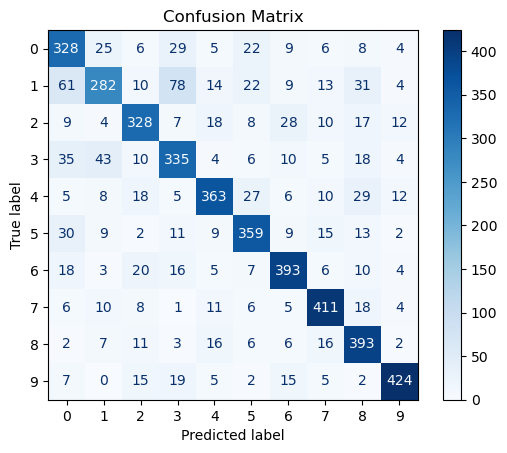

In [27]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




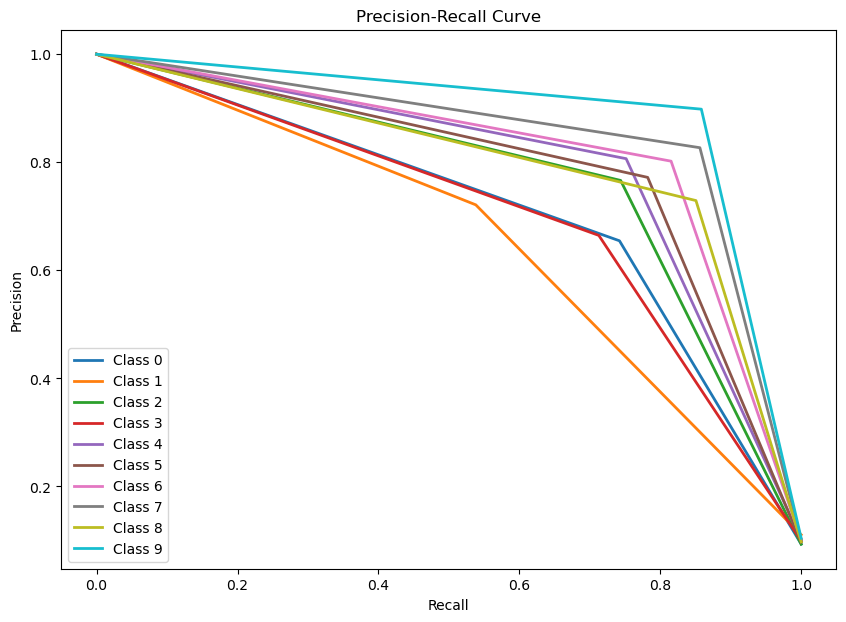

In [28]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Example: Define y_test and y_pred
# Replace these with your actual labels
# y_test = [0, 1, 2, 0, 1, 2]  # True labels
# y_pred = [0, 2, 1, 0, 0, 1]  # Predicted labels

# Get the unique classes and binarize labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

n_classes = y_test_bin.shape[1]

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


In [29]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris




# Plot ROC Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    # Get ROC curve metrics for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)  # Compute AUC for each class
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for random classifier (AUC = 0.5)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Plot details
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")
plt.show()


NameError: name 'y_pred_prob' is not defined

<Figure size 1000x700 with 0 Axes>